<a href="https://colab.research.google.com/github/rrfsantos/Desafios-NLP/blob/main/Desafio-NLP--Classificacao/Tweets_Covid_19_AnaliseSentimentos_GloVe_BiLSTM_5classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de sentimentos (classificação) de tweets relacionados a COVID-19

### Dataset: Coronavirus tweets NLP - Text Classification - https://www.kaggle.com/datatattle/covid-19-nlp-text-classification




In [ ]:
!pip install contractions

     |████████████████████████████████| 266kB 17.7MB/s 
     |████████████████████████████████| 327kB 54.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=85246 sha256=9503e3922c51b7591b27921f53576827d54a239468c5a89f90ceae88d3f7bb84
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


In [ ]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import nltk
import spacy
import re
import string
import unicodedata
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
%matplotlib inline

from contractions import contractions_dict
from tensorflow import keras
from keras.preprocessing import sequence
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn import metrics
from nltk.tokenize import TweetTokenizer

from wordcloud import WordCloud
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#!python -m spacy download en_core_web_md
#!python -m spacy link en_core_web_md en --force

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/desafio 1/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Mounted at /content/drive


In [ ]:
# Carregar as bases de treino e teste
df_train = pd.read_csv('Corona_NLP_train.csv', engine='python')
df_test = pd.read_csv('Corona_NLP_test.csv', engine='python')

In [ ]:
df_train = df_train[['OriginalTweet', 'Sentiment']]
df_test = df_test[['OriginalTweet', 'Sentiment']]

In [ ]:
train = len(df_train)
test = len(df_test)

print('Número de Tweets na base de treino: ', train)
print('Número de Tweets na base de test: ', test)

Número de Tweets na base de treino:  41157
Número de Tweets na base de test:  3798


In [ ]:
df_train['OriginalTweet'][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

## Pré-processamento da base

#### Simplificação de contrações e expressões

In [ ]:
df_train['OriginalTweet'] = df_train.replace({'OriginalTweet': contractions_dict},regex=True)
df_test['OriginalTweet'] = df_test.replace({'OriginalTweet': contractions_dict},regex=True)

#### Removeção caracteres especiais e transformar os demais em minúsculos

In [ ]:
# Expressões regulares
remove_urls     = re.compile(r'https?://\S+|www\.\S+')
remove_hashtags = re.compile(r'#\w+')
remove_emails   = re.compile(r'\S+@\S+')
remove_rt       = re.compile(r'^RT[\s]+')
#remove_numbers  = re.compile(r'\d+')
remove_mentions = re.compile(r'@\w+')
remove_blank = re.compile(r"\s+")

def clean_text(text):

    # Parse HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # Apply regex

    text = remove_hashtags.sub('', text)    # remove hashtags    

    text = remove_emails.sub('', text)      # remove emails

    text = remove_rt.sub('', text)          # remove RT

    text = remove_urls.sub('', text)        # remove urls

    text = remove_mentions.sub('', text)    # remove menções

    text = re.sub('_', ' ', text)

    text = remove_blank.sub(' ',text).strip() # substituiu mais de um espaço em branco
    
    # Encoding-decoding text
    text = text.encode('ascii', 'replace').decode('utf-8')

    # Remove toda a pontuação

    text = re.sub(rf"[{string.punctuation}]", '', text)
       
    return text

df_train['OriginalTweet'] = df_train.OriginalTweet.map(clean_text).str.lower()
df_test['OriginalTweet'] = df_test.OriginalTweet.map(clean_text).str.lower()

In [ ]:
df_train['OriginalTweet'][2]

'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak'

### Lemetização

In [ ]:
#nlp = spacy.load('en')

#def lemmatize(text):
#  text = nlp(text)
#  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
#  return text

#df_train['OriginalTweet'] = df_train.OriginalTweet.map(lemmatize)
#df_test['OriginalTweet'] = df_test.OriginalTweet.map(lemmatize)

### Tokenização

In [ ]:
tk = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

df_train['OriginalTweet'] = df_train.OriginalTweet.apply(tk.tokenize)
df_test['OriginalTweet'] = df_test.OriginalTweet.apply(tk.tokenize)

#### Remoção de stop words

In [ ]:
#stopword_list = nltk.corpus.stopwords.words('english')
#new_stopwords = ['pic','twitter','com','amp']
#stopword_list.extend(new_stopwords)
#stopword_list.remove('no')
#stopword_list.remove('not')

#stop_lambda = lambda x: [y for y in x if y not in stopword_list]

#df_train['OriginalTweet'] = df_train.OriginalTweet.map(stop_lambda)
#df_test['OriginalTweet'] = df_test.OriginalTweet.map(stop_lambda)

### Remoção de números, pontuação, caracteres especiais ou de palavras que possuam apenas um caractere

In [ ]:
def is_alpha(text):
  text = [token for token in text if token.isalpha() and len(token) > 1]
  return ' '.join(text)

df_train['OriginalTweet'] = df_train.OriginalTweet.apply(is_alpha)
df_test['OriginalTweet'] = df_test.OriginalTweet.apply(is_alpha)

In [ ]:
df_train['OriginalTweet'][20]

'with nations inficted with covid the world must not play fair with china goverments must dthemand china adopts new guilde lines on food safty the chinese goverment is guilty of being irosponcible with life on global scale'

### Tratamento de dados faltantes após o pré-processamento

In [ ]:
# Substitui as colunas vazias por "NaN"
df_train.loc[df_train['OriginalTweet'] == '', ['OriginalTweet']]= np.nan
df_test.loc[df_test['OriginalTweet'] == '', ['OriginalTweet']]= np.nan


# Verifica se há dados faltantes na base
print('Base de treino', '-' * 15 , df_train.isna().sum(), sep='\n')

print('\nBase de test', '-' * 15 , df_test.isna().sum(), sep='\n')


Base de treino
---------------
OriginalTweet    38
Sentiment         0
dtype: int64

Base de test
---------------
OriginalTweet    2
Sentiment        0
dtype: int64


In [ ]:
# Remove os dados faltantes da base de treino
df_train.dropna(inplace=True)

# Remove os dados faltantes da base de teste
df_test.dropna(inplace=True)

## Análises estatísticas

#### Distribuição de tweets por Classe

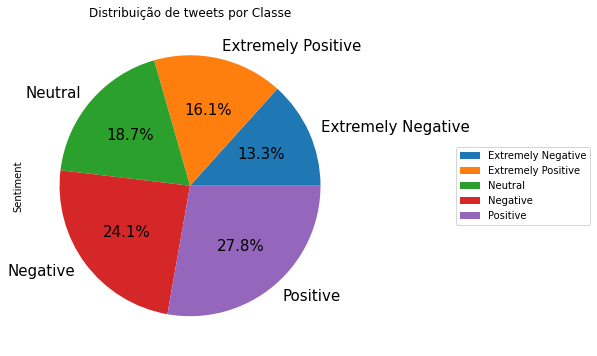

In [ ]:
df_distribution = df_train.Sentiment.value_counts()\
                            .to_frame()\
                            .sort_values('Sentiment')

df_distribution.plot.pie(y='Sentiment', autopct='%1.1f%%',\
                            title='Distribuição de tweets por Classe',\
                            figsize=(6, 6), textprops = {"fontsize": 15}, labeldistance = 1.1)\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5),fontsize='medium')

plt.show;   

#### Tamanho dos tweets por classe

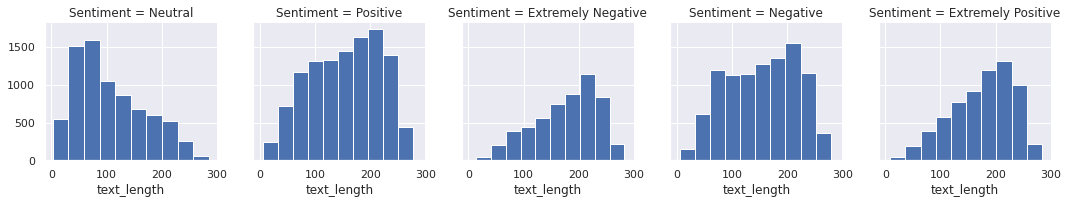

In [ ]:
df_train['text_length'] = df_train.OriginalTweet.apply(len)
sns.set(font_scale = 1)
g = sns.FacetGrid(df_train,col='Sentiment')
g.map(plt.hist,'text_length')
plt.show();

#### Quantidade de caracteres nos tweets

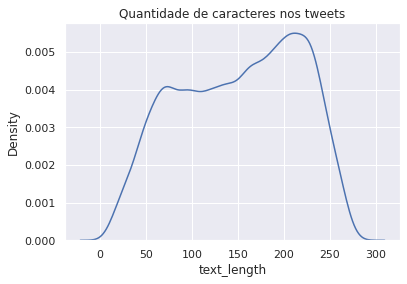

In [ ]:
sns.distplot(df_train.text_length, hist=False)
plt.title('Quantidade de caracteres nos tweets')
plt.show();

#### Distribuição da quantidade de palavras nos tweets

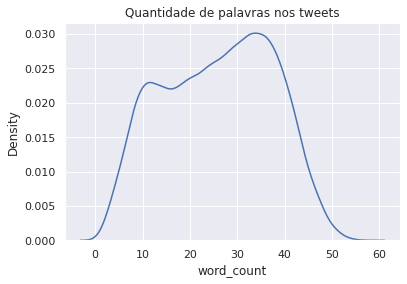

In [ ]:
df_train['word_count'] = df_train.OriginalTweet.apply(lambda x: len(str(x).split()))
sns.distplot(df_train.word_count, hist=False)
plt.title('Quantidade de palavras nos tweets')
plt.show();

## WordCloud

In [ ]:
### Verifica ngrams
def get_top_text_ngrams(text, n, g):
  vec = CountVectorizer(ngram_range=(g, g)).fit(text)
  bag_of_words = vec.transform(text)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

### Unigrams

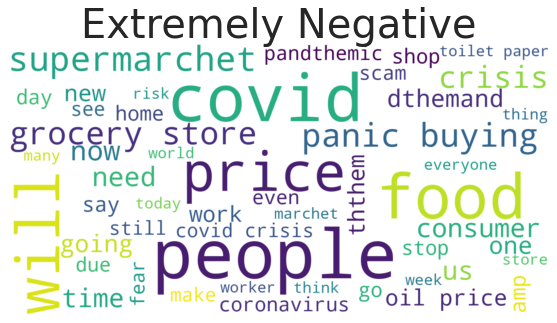

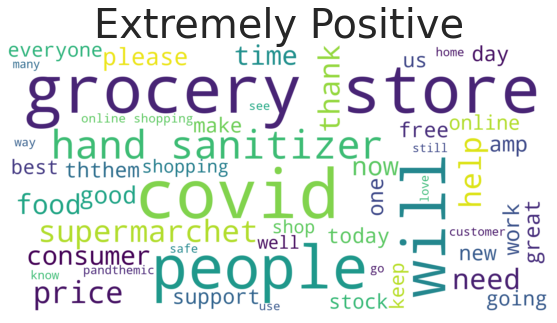

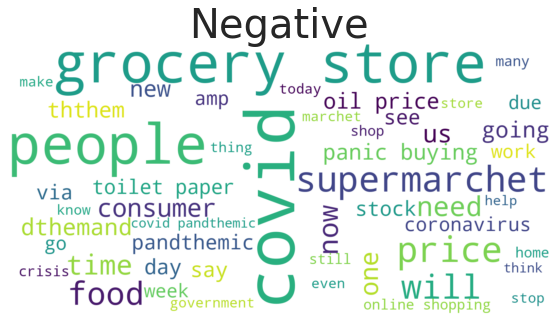

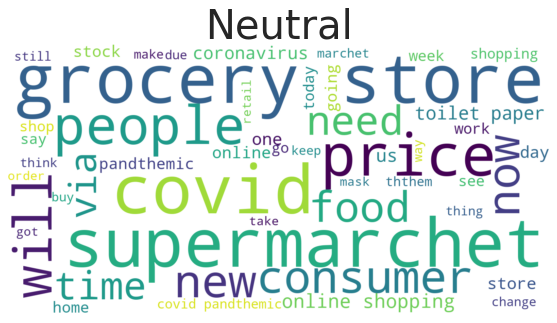

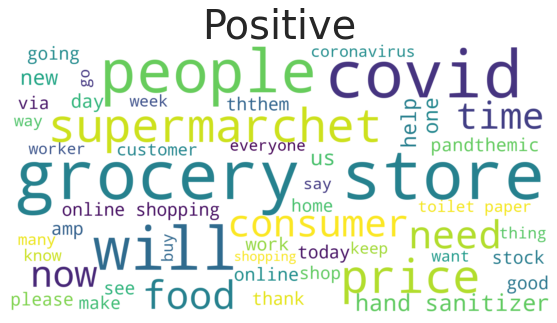

In [ ]:
### Converte lista strings em um único texto
labels = np.unique(df_train.Sentiment)
for label in labels:
    rows = df_train[df_train.Sentiment == label]
    corpus = " ".join(text for text in rows.OriginalTweet)
      
    ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate(corpus)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;  

### Bigrams

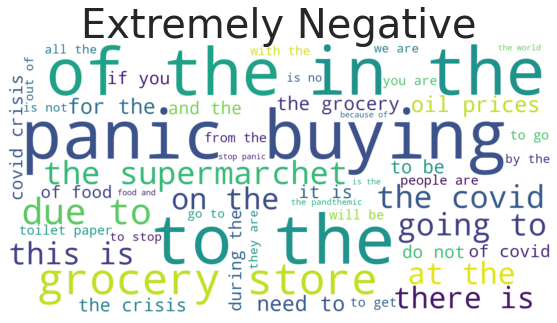

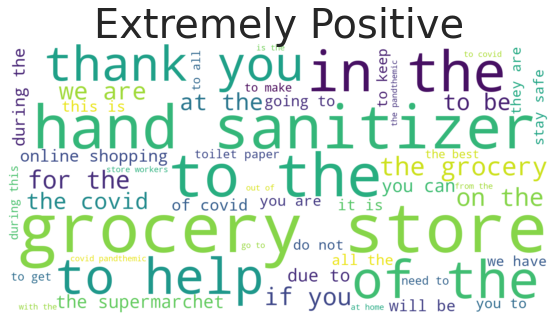

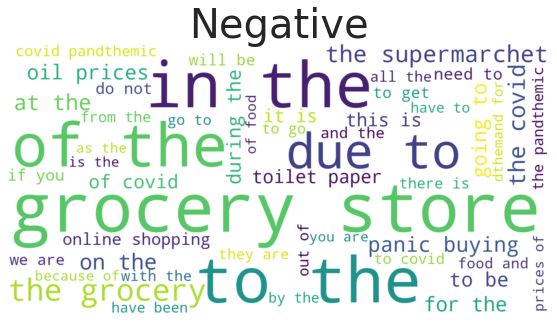

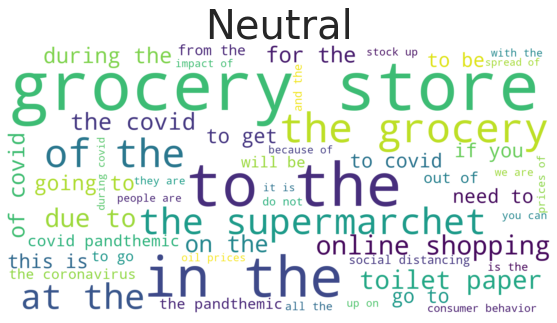

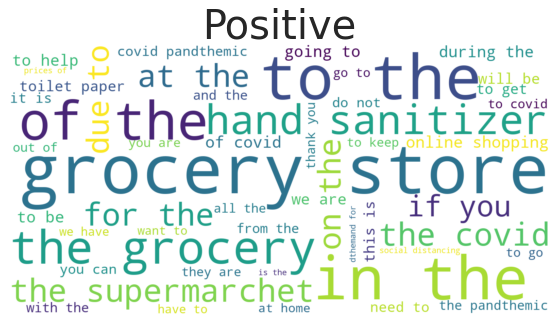

In [ ]:
### Converte lista de strings em um único texto
labels = np.unique(df_train.Sentiment)
corpus = []
for label in labels:
    rows = df_train[df_train.Sentiment == label]
    most_common = get_top_text_ngrams(rows.OriginalTweet,50,2)
    most_common = dict(most_common)

       ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;

   

### Trigrams

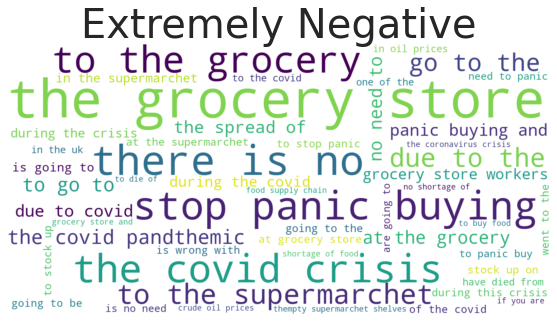

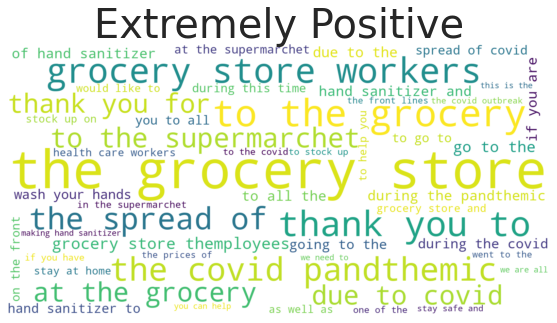

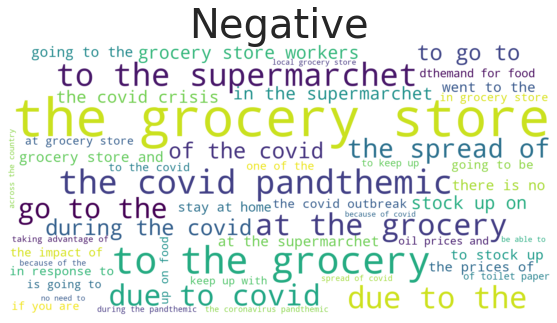

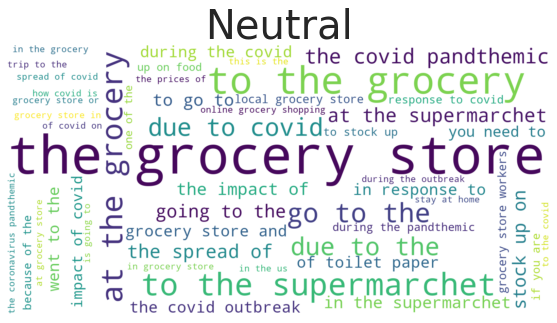

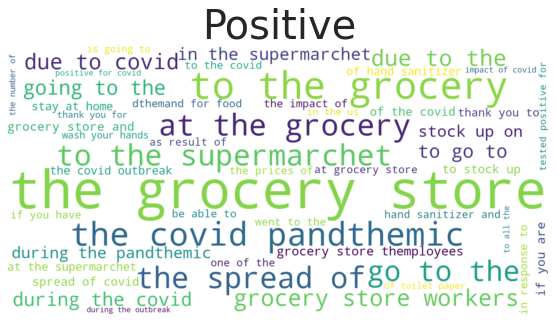

In [ ]:
### Converte lista de strings em um único texto
labels = np.unique(df_train.Sentiment)
corpus = []
for label in labels:
    rows = df_train[df_train.Sentiment == label]
    most_common = get_top_text_ngrams(rows.OriginalTweet,50,3)
    most_common = dict(most_common)

       ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;

## Análise de Sentimentos - Classificação dos Tweets - Embedding + Transformer + GRU

#### Transformar labels (coluna Sentiment) em dados numéricos e dividir as bases de treino e teste em atributos e labels (X,y)

In [ ]:
le = LabelEncoder()
y_train  = le.fit_transform(df_train['Sentiment'])   # teste
y_test  = le.transform(df_test['Sentiment'])   # teste
target_names = le.classes_ # armazena o nome dos atributos e classe

X_train = df_train.OriginalTweet
X_test = df_test.OriginalTweet

print(target_names, y_train, sep='\n\n')

['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive']

[3 4 4 ... 4 3 2]


#### Variáveis

In [ ]:
batch_size = 32
epochs = 100
max_features = 10000 # número máximo de palavras utilizado para o vocabulário (número de "vetores de palavras")
init_lr = 1e-3
seed = 100
num_classes = df_train['Sentiment'].nunique()

#### Criar os vetores de palavras

In [ ]:
np.random.seed(seed)

In [ ]:
max_features = max_features
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
maxlen = 60 # número máximo de palavras em um comentário
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print(X_train.shape,X_test.shape)

(41119, 60) (3796, 60)


#### Callbacks

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True, verbose = True, monitor='val_loss', mode='min')
mc = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, verbose=True, monitor='val_loss', mode='min')
rlr = ReduceLROnPlateau(patience = 2, verbose = True, factor=0.5, monitor='val_loss', restore_best_weights=True, mode='min')

#### Otimizador

In [ ]:
#opt = RMSprop(learning_rate=init_lr, momentum=0.1)
opt = Adam(learning_rate=init_lr, amsgrad = True)

#### Camada Embedding da Rede Neural

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features=max_features):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return max_features, embedding_matrix

# embedding matrix
EMBEDDING_FILE = 'glove.twitter.27B.100d.txt' ### Teste anterior com glove.6B.100d.txt
embed_dim = 100 # --> Cada palavra é representada por um vetor de 100 dimensões (glove.6B.100d.txt)
max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)    

Found 1193514 word vectors.


#### Camada Transformer da Rede Neural

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

#### Montar a Rede Neural

In [ ]:
K.clear_session()
num_heads = 2
ff_dim = embed_dim
model = Sequential()

## Camada Embedding
embedding_layer = Embedding(max_features, embed_dim, input_length=X_train.shape[1],
                       weights=[embedding_matrix], trainable = True)

## Camada Transformer
transformer_layer = TransformerBlock(embed_dim, num_heads, ff_dim)
  
## Montagem da Rede Neural
inputs = layers.Input(shape=(maxlen,))
x = embedding_layer(inputs)
#x = transformer_layer(x)
x = layers.Bidirectional(LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(x)
#x = layers.GlobalAveragePooling1D()(x) 
x = layers.Dense(64, activation="relu")(x)  
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics=['acc'])

print(model.summary())    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                12864     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 1,173,989
Trainable params: 1,173,989
Non-trainable params: 0
_________________________________________________________________
None


#### Treinar a Rede Neural

In [ ]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train,validation_split=0.1, epochs=epochs, batch_size=batch_size,callbacks=[es, rlr])                       

Epoch 1/100
1157/1157 [==============================] - 451s 384ms/step - loss: 1.2699 - accuracy: 0.4415 - val_loss: 0.7078 - val_accuracy: 0.7454
Epoch 2/100
1157/1157 [==============================] - 443s 383ms/step - loss: 0.6620 - accuracy: 0.7606 - val_loss: 0.5362 - val_accuracy: 0.8161
Epoch 3/100
1157/1157 [==============================] - 445s 384ms/step - loss: 0.5098 - accuracy: 0.8272 - val_loss: 0.4931 - val_accuracy: 0.8315
Epoch 4/100
1157/1157 [==============================] - 443s 383ms/step - loss: 0.4261 - accuracy: 0.8526 - val_loss: 0.4866 - val_accuracy: 0.8393
Epoch 5/100
1157/1157 [==============================] - 445s 385ms/step - loss: 0.3715 - accuracy: 0.8739 - val_loss: 0.5129 - val_accuracy: 0.8317
Epoch 6/100
1157/1157 [==============================] - 443s 383ms/step - loss: 0.3320 - accuracy: 0.8874 - val_loss: 0.5186 - val_accuracy: 0.8273

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
1157/1157 [==

#### Função verificação do Histórico de Treinamento

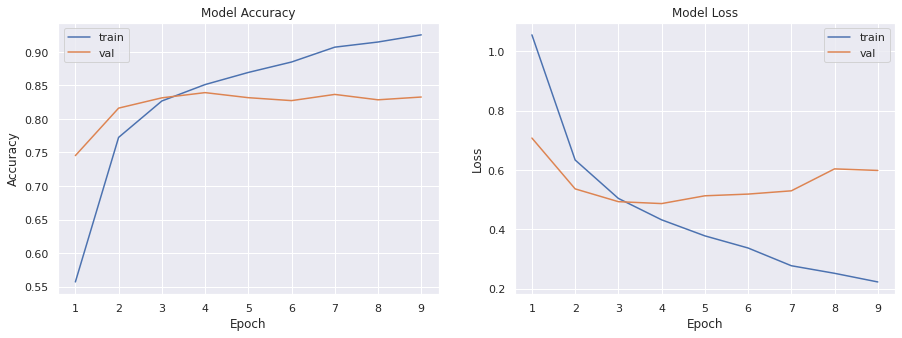

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show(); 

plot_model_history(history)       

#### Função para avalição da Rede Neural

Accuracy das previsões feitas pelo modelo:	79.1%


              precision    recall  f1-score   support

           0       0.78      0.84      0.81       592
           1       0.83      0.83      0.83       599
           2       0.78      0.73      0.75      1041
           3       0.91      0.82      0.86       617
           4       0.73      0.79      0.76       947

    accuracy                           0.79      3796
   macro avg       0.80      0.80      0.80      3796
weighted avg       0.79      0.79      0.79      3796



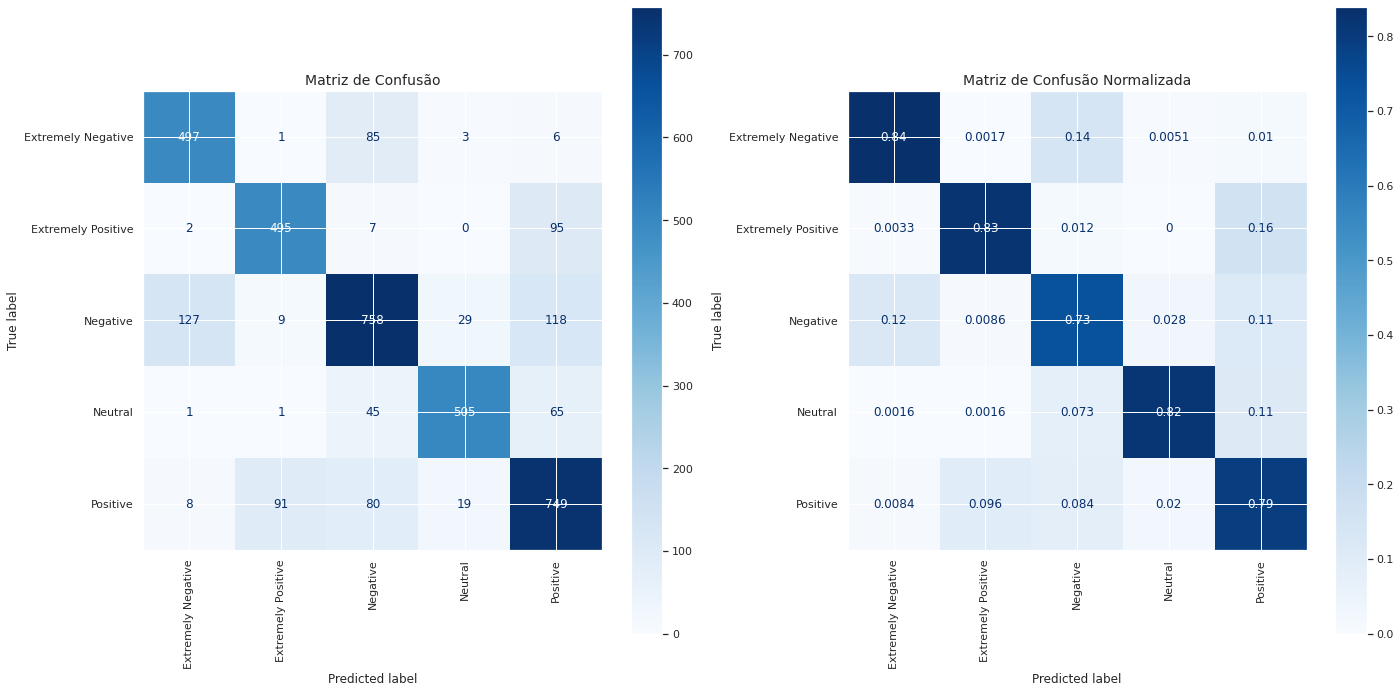

In [ ]:
def model_evaluate():

    # predict class with test set
    y_pred_test = np.argmax(model.predict(X_test), axis=1)
    
    print('Accuracy das previsões feitas pelo modelo:\t{:0.1f}%'.format(accuracy_score(y_test, y_pred_test)*100))
    
    # classification report
    print('\n')
    print(classification_report(y_test, y_pred_test))

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Matriz de confusão
        
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax[0], values_format='') 
    ax[0].set_title('Matriz de Confusão', fontsize=14)
    

    # Matriz de confusão dados normalizados (proporções)

    cm_norm = confusion_matrix(y_test, y_pred_test, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax[1])
    ax[1].set_title('Matriz de Confusão Normalizada', fontsize=14)

    plt.tight_layout();
model_evaluate()    